# Gene cluster visualization

In [10]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from starmap.sequencing import *
from natsort import natsorted
from scipy.io import loadmat, savemat
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from tqdm import tqdm

from skimage.measure import find_contours
from matplotlib.colors import ListedColormap
from skimage.segmentation import find_boundaries

### Functions

In [11]:
from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it


@timer
# Load reads and their positions from mat file
def load_reads(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 1]-1)
    temp[:, 1] = np.round(points[:, 0]-1)
    temp[:, 2] = np.round(points[:, 2]-1)
    
    print(f"Number of reads: {len(bases)}")
    
    return bases, temp


# Load gene table from genes.csv
def load_genes(fpath):
    genes2seq = {}
    seq2genes = {}
    with open(os.path.join(fpath, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            genes2seq[fields[0]] = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            seq2genes[genes2seq[fields[0]]] = fields[0]
    return genes2seq, seq2genes

## Input path

In [12]:
# IO path 
base_path = 'Z:/Data/Analyzed/2021-07-16-Rena-Hela-EU/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
sample_dict = {'20h_labeling': '20h labeling',
               '1h_labeling_6h_wash': '1h labeling, 6h wash',
               '1h_labeling_4h_wash': '1h labeling, 4h wash',
               '1h_labeling_2h_wash': '1h labeling, 2h wash',
               '1h_labeling_1h_wash': '1h labeling, 1h wash',
               '1h_labeling': '1h labeling'}

sample_dirs = list(sample_dict.keys())
sample_dirs

['20h_labeling',
 '1h_labeling_6h_wash',
 '1h_labeling_4h_wash',
 '1h_labeling_2h_wash',
 '1h_labeling_1h_wash',
 '1h_labeling']

## Load gene cluster label

In [13]:
# load gene cluters
gene_cluster_df = pd.read_excel(os.path.join(base_path, 'gene_modules/2022-01-06-gene-cluster-label.xlsx'))

# modify df
cluster_GO_dict = {'DNA-binding':0, 'Cell-cell junction':1, 'RNA-binding':2, 'Cell division':3, np.nan:999}
gene_cluster_df['cluster_GO'] = gene_cluster_df['cluster_GO'].map(cluster_GO_dict)
gene_cluster_df['cluster_GO'] = gene_cluster_df['cluster_GO'].astype(np.int64)

gene_cluster_df

,gene,cluster_kinetics,cluster_GO
0,AARS,2,999
1,ASXL1,1,0
2,COX7B,3,999
3,CTGF,2,999
4,DLX4,2,999
...,...,...,...
803,ZRANB1,1,999
804,ZSCAN12,2,0
805,ZSCAN29,2,0
806,ZXDC,1,0


In [14]:
# load m6A / DC1 labels
m6a_dc1_df = pd.read_excel(os.path.join(base_path, 'gene_modules/2022-01-09-m6A-DC1-gene-label.xlsx'))
m6a_dc1_df.columns = ['gene', 'm6A label', 'DC1 target']

# modify
m6a_dc1_df['m6A label new'] = 999
m6a_dc1_df.loc[(m6a_dc1_df['m6A label'] == 'm6A') & (m6a_dc1_df['DC1 target'] == 'target'), 'm6A label new'] = 0
m6a_dc1_df.loc[m6a_dc1_df['m6A label'] == 'non m6A', 'm6A label new'] = 1

m6a_dc1_df

,gene,m6A label,DC1 target,m6A label new
0,DGCR11,other,other,999
1,SNHG20,other,non target,999
2,SSR2,m6A,other,999
3,TSPAN3,m6A,other,999
4,AASS,other,other,999
...,...,...,...,...
993,PTRH2,m6A,target,0
994,CBX4,m6A,target,0
995,NDUFS4,other,non target,999
996,NDUFS7,non m6A,non target,1


## Visualization

### Single cell

In [ ]:
# plot_single_cell_pattern
def plot_single_cell_pattern(base_path, sample, orig_index, input_df, plot_field,
                            bg_color, nuclei_color, cell_color, spot_colors):
    
    # set path 
    input_path = os.path.join(base_path, sample)
    
    # load image
    current_dapi_label = load_label_image(input_path, fname='dapi_label.tiff')
    current_cell_label = load_label_image(input_path, fname='overlay_label.tiff')
    
    # load gene info
    genes2seqs, seqs2genes = load_genes(base_path)

    # Load reads 
    bases, points = load_reads(input_path, "merged_goodPoints_max3d_new.mat")
    bases = np.array(bases)
    points = np.array(points)
    
    # find cell
    dapi = None
    cell = None
    for i, region in enumerate(regionprops(current_dapi_label)):
        if region.label == orig_index + 1:
            dapi = region 
            
    for i, region in enumerate(regionprops(current_cell_label)):
        if region.label == orig_index + 1:
            cell = region 

In [238]:
# basic parameters
# sample = '1h_labeling_6h_wash'
sample = '20h_labeling'
orig_index = 873
input_df = gene_cluster_df
plot_field = 'cluster_kinetics'

# visual
bg_color = 'k'
nuclei_color = ''
cell_color = ''
spot_colors = []

# set path 
input_path = os.path.join(base_path, sample)

# load image
current_dapi_label = load_label_image(input_path, fname='dapi_label.tiff')
current_cell_label = load_label_image(input_path, fname='overlay_label.tiff')
current_segmentation = load_label_image(input_path, fname='cell.tif')
# load gene info
genes2seqs, seqs2genes = load_genes(base_path)

# Load reads 
bases, points = load_reads(input_path, "merged_goodPoints_max3d_new.mat")
bases = np.array(bases)
points = np.array(points)

Number of reads: 3083234
Total execution time: 21.385 s


In [239]:
# find cell
cell = current_cell_label == orig_index + 1
dapi = np.where(cell, current_dapi_label, 0)

cell_region = None
for i, region in enumerate(regionprops(current_cell_label)):
    if region.label == orig_index + 1:
        cell_region = region
        
cell_bbox = cell_region.bbox
cell_crop = cell[cell_bbox[0]:cell_bbox[2], cell_bbox[1]:cell_bbox[3]]
dapi_crop = dapi[cell_bbox[0]:cell_bbox[2], cell_bbox[1]:cell_bbox[3]]
dapi_crop = dapi_crop > 0

# final_crop = np.where(cell_crop, 2, 0)
# final_crop = np.where(dapi_crop, 1, final_crop)
# cell_crop = np.where(dapi_crop, 1, cell_crop)

# get alignment 
offset = 500
bg = np.zeros([offset, offset], np.uint8)
bbox_center = np.array(dapi_crop.shape) / 2
bbox_new_origin = [int(offset / 2 - bbox_center[0]), int(offset / 2 - bbox_center[1])]
# bg[bbox_new_origin[0]:bbox_new_origin[0] + cell_crop.shape[0], bbox_new_origin[1]:bbox_new_origin[1] + cell_crop.shape[1]] = final_crop

# get nuclei / cell contour
bg[bbox_new_origin[0]:bbox_new_origin[0] + cell_crop.shape[0], bbox_new_origin[1]:bbox_new_origin[1] + cell_crop.shape[1]] = cell_crop
cell_bnd = find_contours(bg>0, level=.5)

bg[bbox_new_origin[0]:bbox_new_origin[0] + cell_crop.shape[0], bbox_new_origin[1]:bbox_new_origin[1] + cell_crop.shape[1]] = dapi_crop
dapi_bnd = find_contours(bg>0, level=.5)

# get reads 
points = points.astype(int)
reads_assignment = current_segmentation[points[:, 2], points[:, 0], points[:, 1]]

reads_info = pd.DataFrame({'x':points[:, 0], 'y':points[:, 1], 'z':points[:, 2], 'cell_label':reads_assignment})
reads_info = reads_info.astype(np.int32)
reads_info['orig_index'] = reads_info['cell_label'] - 1
reads_info['gene'] = bases
reads_info = reads_info.loc[reads_info['orig_index'] == orig_index, :]
reads_info = pd.merge(reads_info, input_df)

# get reads shift 
shifts = [bbox_new_origin[0] - cell_bbox[0], bbox_new_origin[1] - cell_bbox[1]]
reads_info['x'] = reads_info['x'] + shifts[0] 
reads_info['y'] = reads_info['y'] + shifts[1] 

In [240]:
nuclei_color = np.array((255, 255, 255)) / 255
cell_color = np.array((255, 255, 255)) / 255

spot_colors = ['#A895E6', '#22E6A2', '#E6350B', '#EBDB34'] 
cpl = sns.color_palette(spot_colors)
cpl

[(0.6588235294117647, 0.5843137254901961, 0.9019607843137255),
 (0.13333333333333333, 0.9019607843137255, 0.6352941176470588),
 (0.9019607843137255, 0.20784313725490197, 0.043137254901960784),
 (0.9215686274509803, 0.8588235294117647, 0.20392156862745098)]

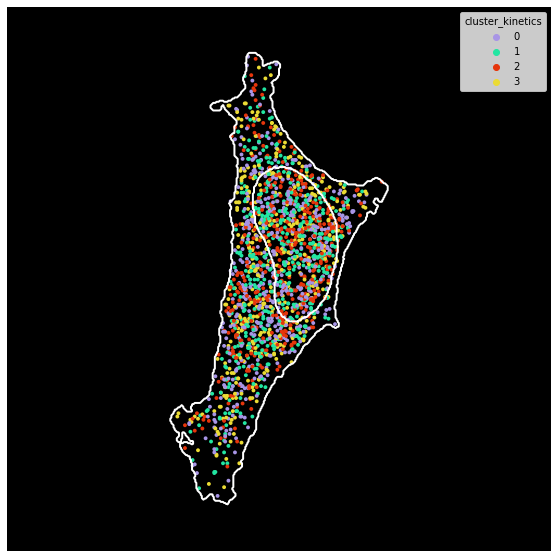

In [242]:
linewidth = 2
bg = np.zeros([offset, offset], np.uint8)

plt.subplots(figsize=(10, 10))
plt.imshow(bg, cmap='Greys_r')
for contour in dapi_bnd:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, c=nuclei_color)

for contour in cell_bnd:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, c=cell_color)

sns.scatterplot(x="y", y="x", hue=plot_field,
                linewidth=0, s=15, palette=cpl,
                data=reads_info)
plt.axis('off')
plt.savefig(os.path.join(out_path, '20h_labeling_873.pdf'))
plt.show()

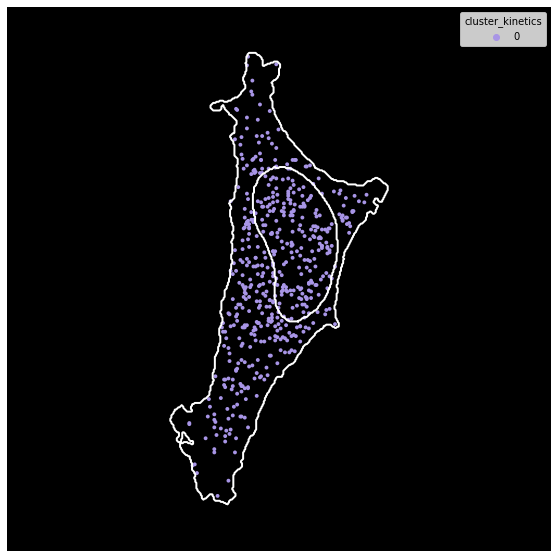

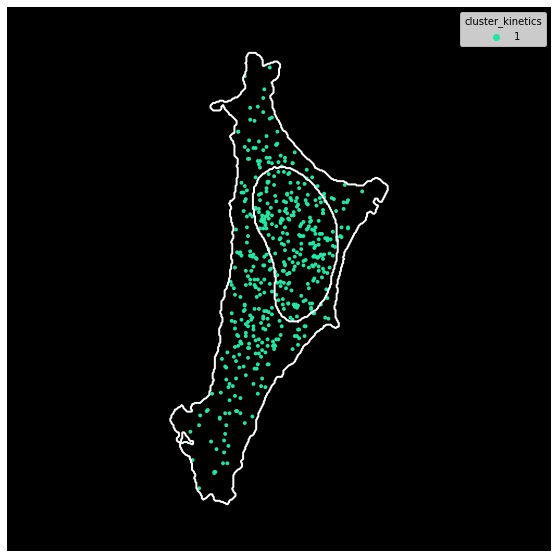

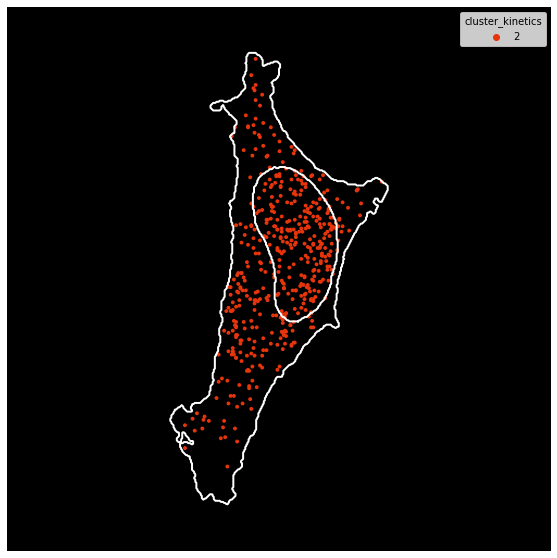

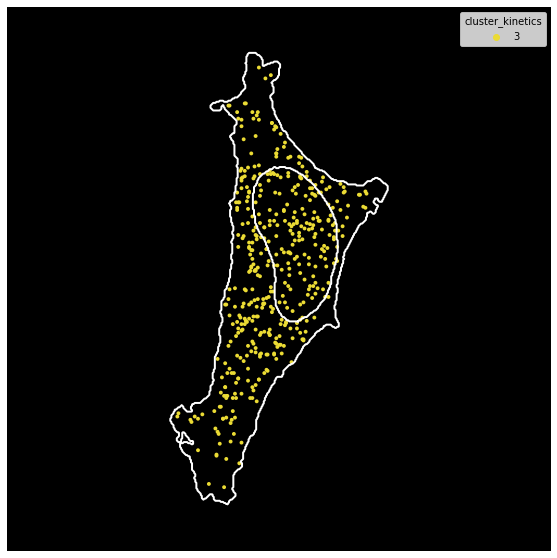

In [256]:
linewidth = 2
bg = np.zeros([offset, offset], np.uint8)

for i, cluster in enumerate(sorted(reads_info['cluster_kinetics'].unique())):
    
    plt.subplots(figsize=(10, 10))
    plt.imshow(bg, cmap='Greys_r')
    for contour in dapi_bnd:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, c=nuclei_color)

    for contour in cell_bnd:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, c=cell_color)

    sns.scatterplot(x="y", y="x", hue=plot_field,
                    linewidth=0, s=15, palette=sns.color_palette(spot_colors[i:i+1]),
                    data=reads_info.loc[reads_info['cluster_kinetics'] == cluster, :])

    plt.axis('off')
    # plt.savefig(os.path.join(out_path, '20h_labeling_873.pdf'))
    plt.show()

In [ ]:
# basic parameters
sample = '20h_labeling'
orig_index = 0
input_df = gene_cluster_df
plot_field = 'cluster_kinetics'

# visual
bg_color = 'k'
nuclei_color = ''
cell_color = ''
spot_colors = []

plot_single_cell_pattern(base_path, sample, orig_index, input_df, plot_field,
                            bg_color, nuclei_color, cell_color, spot_colors)